In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.nonlinear_stokes.nonlinear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
    loss_domain_fn,
    get_p,
    get_u,
    deviatoric_stress
)

from src.nonlinear_stokes.nonlinear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [2]:
args = parser.parse_args("")
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

/usr/local/anaconda3/envs/dvvf/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3000.803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [3]:
u_p = solve_fenics(params)

In [4]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

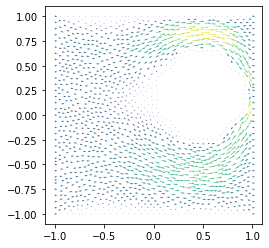

In [5]:
u, p = u_p.split()
fa.plot(u)

In [6]:
x0 = points_in_domain[120]

In [7]:
taylor = SecondOrderTaylorLookup(u_p, all_points, d = 3)

In [8]:
direction = np.array([-1./np.sqrt(2), 1./np.sqrt(2)])
epsilon = []
error = []
u_p.set_allow_extrapolation(True)
for i in range(20):
    eps = 1e-12 * 5**i
    x = x0 + direction * eps
    y = np.array(u_p(x))
    yhat = np.array(taylor(x)).reshape(y.shape)
    err = np.linalg.norm(y - yhat)
    epsilon.append(eps)
    error.append(err)
    rel_err = err/np.linalg.norm(y)
    print("delta size: {}, rel err {:.3e}".format(eps, rel_err))
u_p.set_allow_extrapolation(False)

delta size: 1e-12, rel err 2.985e-08
delta size: 5e-12, rel err 2.985e-08
delta size: 2.5e-11, rel err 2.985e-08
delta size: 1.25e-10, rel err 2.985e-08
delta size: 6.25e-10, rel err 2.985e-08
delta size: 3.125e-09, rel err 2.985e-08
delta size: 1.5625e-08, rel err 2.985e-08
delta size: 7.812499999999999e-08, rel err 3.031e-08
delta size: 3.9062499999999997e-07, rel err 1.277e-07
delta size: 1.953125e-06, rel err 3.761e-07
delta size: 9.765625e-06, rel err 1.788e-06
delta size: 4.8828124999999996e-05, rel err 8.837e-06
delta size: 0.000244140625, rel err 4.395e-05
delta size: 0.001220703125, rel err 2.186e-04
delta size: 0.006103515625, rel err 1.067e-03
delta size: 0.030517578125, rel err 1.492e-03
delta size: 0.152587890625, rel err 9.603e-04
delta size: 0.762939453125, rel err 4.906e-02
delta size: 3.814697265625, rel err 2.176e+01
delta size: 19.073486328125, rel err 5.942e+00


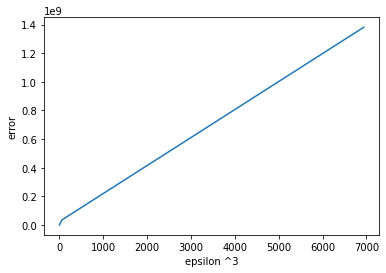

In [9]:
plt.figure()
plt.plot(np.array(epsilon)**3, error)
plt.xlabel('epsilon ^3')
plt.ylabel('error')
plt.show()

In [10]:
y = np.array(u_p(x0))
yhat = np.array(taylor(x0)).reshape(y.shape)
np.linalg.norm(y - yhat)

0.00040909016986495476

# Loss Function 

(2,)
[31737894. 45983990.]
[4543.8506 1658.5464]


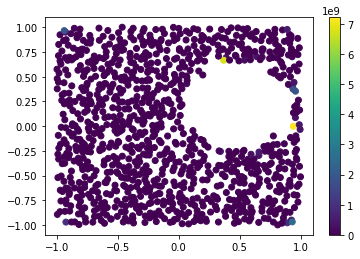

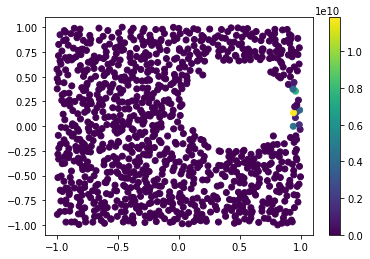

In [11]:
jax_domain_loss = loss_domain_fn(taylor, points_in_domain, params)
print(np.mean(jax_domain_loss, axis=0))
print(np.median(jax_domain_loss, axis=0))

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_domain_loss[:,0]))
plt.colorbar(clrs)
plt.show()

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_domain_loss[:,1]))
plt.colorbar(clrs)
plt.show()

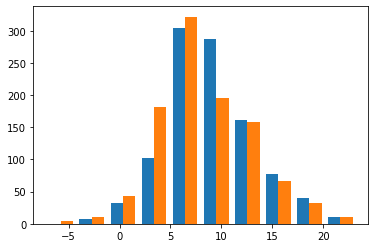

In [12]:
plt.figure()
plt.hist(np.log(jax_domain_loss))
plt.show()

# Check Gradient for Pressure

In [13]:
taylor_p = get_p(taylor)

In [14]:
grad_taylor_p = jax.grad(taylor_p)
grad_taylor_p(x0)

DeviceArray([-5459.58 ,  8810.551], dtype=float32)

In [15]:
# Gradient for p 
Vp = fa.VectorFunctionSpace(p.function_space().mesh(), 'P', 2, 2)
pg = fa.project(fa.grad(p), Vp)

In [16]:
p

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 7), FiniteElement('Lagrange', triangle, 1)), 159)

In [17]:
p(x0)

-11746.526036030997

In [18]:
pg(x0)

array([-5459.58008425,  8810.55114838])

In [19]:
grad_taylor_p_val = []
grad_fenics_p_val = []
for pt in points_in_domain:
    grad_taylor_p_val.append(grad_taylor_p(pt))
    grad_fenics_p_val.append(pg(pt))
# compute error
grad_p_err = np.abs(np.array(grad_taylor_p_val) - np.array(grad_fenics_p_val))/np.array(np.array(grad_fenics_p_val))
grad_p_err.mean(axis=0)

array([-1.21485489e-08,  1.12766802e-09])

# Check Gradient for Velocity

In [20]:
taylor_u = get_u(taylor)

In [21]:
deviatoric_stress(x0, taylor_u, source_params)

(2,)


DeviceArray([[-1195.786  ,   496.31024],
             [  496.31024,  1202.4574 ]], dtype=float32)

In [22]:
jacobian_taylor_u = jax.jacfwd(lambda x: taylor_u(x).squeeze())

In [23]:
# Gradient for u 
Vp = fa.TensorFunctionSpace(u.function_space().mesh(), 'P', 2, (2,2))
ug = fa.project(fa.grad(u), Vp)

In [24]:
x0 = points_in_domain[35]
u(x0)

array([174.22824414, -70.92369822])

In [25]:
jacobian_taylor_u(x0).flatten()

DeviceArray([-4736.2656 ,  -693.78516,   885.5827 ,  4692.3564 ], dtype=float32)

In [26]:
ug(x0)

array([-4736.26561052,  -693.78518332,   885.58271705,  4692.35649593])

In [27]:
grad_taylor_u_val = []
grad_fenics_u_val = []
for pt in points_in_domain:
    grad_taylor_u_val.append(jacobian_taylor_u(pt).flatten())
    grad_fenics_u_val.append(ug(pt))
# compute error
grad_u_err = np.abs(np.array(grad_taylor_u_val) - np.array(grad_fenics_u_val))/np.array(np.array(grad_fenics_u_val))
grad_u_err.mean(axis=0)

array([ 3.40967586e-09,  5.60521107e-10, -1.81122167e-09, -2.69228961e-09])

In [28]:
grad_u0 = jax.grad(lambda x: taylor_u(x).squeeze()[0])
u0, u1 = fa.split(u)
u0g = fa.project(fa.grad(u0), fa.VectorFunctionSpace(u.function_space().mesh(), 'P', 2))

In [29]:
u0g(x0)

array([-4736.26561052,  -693.78518332])

In [30]:
grad_u0(x0)

DeviceArray([-4736.2656 ,  -693.78516], dtype=float32)

In [31]:
hess_u0 = jax.jacfwd(grad_u0)
u0h = fa.project(fa.grad(u0g), fa.TensorFunctionSpace(u.function_space().mesh(), 'P', 2, shape=(2, 2)))

In [32]:
hess_u0(x0)

DeviceArray([[59070.45 , 14692.518],
             [14692.518, 36952.266]], dtype=float32)

In [33]:
u0h(x0)

array([59070.44784649, 15136.35687737, 14248.679905  , 36952.26635045])